# **Predicting Wine Quality Through Classification and Regression**
#### DSCI 100 Winter T2 Group 006-042

## Introduction:

Consumer selection on wine has been heavily dependent on quality certifications for purchasing decisions and producers have been doing the same for pricing (Cortez et al., 2009). The certification for wine quality is a tedious process, requiring trained wine assessors to sample the taste and smell of the wine to determine its quality (Cortez et al., 2009). However, there are biases when conducting these sensory taste tests due to personal preferences of the experts and the complex nature of the human taste bud (Smith and Margolskee, 2001). In a study conducted on 571 wine experts, it was found that there was great variation in the individual's ability to produce repeatable ratings for the same wine (Gawl & Godden, 2008). Therefore, within the wine quality assessment industry, it is common to recruit panels of testers for evaluating and comparing wines for greatest consistency, which adds to the cost of assessment.

The lack of consistency and the tedious process of human evaluation suggest that an alternative method for quality evaluation is very desirable. We would like to know whether it is possible to obtain an accurate model to predict wine quality based on its chemical properties, thus, aiding with the quality assessment processes and potentially replacing human sensory evaluators entirely. Furthermore, the analysis may also raise the question of whether subjective experience or objective measures matter more in making wine quality judgements. For this purpose, we use KNN classification over a dataset containing the chemical properties and quality scores of 1599 red wine samples.

Since the chemical variables analyzed in this project can be controlled and manipulated during the production process. Our work aims to integrate subjective rankings to objective measures such that people can extrapolate these findings and improve wine productions.

The data set is collected by Cortez et al. in 2009 and consists of the following variables:

#### Attribute (units):
- Fixed acidity ($g/dm^3$)
- Volatile acidity ($g/dm^3$)
- Citric acid ($g/dm^3$)
- Residual sugar ($g/dm^3$)
- Chlorides ($g/dm^3$)
- Free sulfur dioxide ($mg/dm^3$)
- Total sulfur dioxide ($mg/dm^3$)
- Density ($g/cm^3$)
- pH
- Sulphates ($g/dm^3$)
- Alcohol ($vol.\%$)
- Quality (from 0 to 10)

The quality variable is the average score given by 3 human assessors from a scale of 0-10 (0 being bad and 10 being good). We will not be using every variable provided because some chemical properties do not have an affect on the taste and smell of wine while others do. For example, acidity and alcohol content was found to correspond to the spiciness of the wine (Gutiérrez-Escobar et al., 2021) whereas sulfur dioxide and sulfates (which are primarily used for preservational purposes) impact the aroma and taste of wine (Arapitsas et al., 2018). We will further describe the variable selection process in the upcoming section.

## Methods and Results:

#### Preliminary Exploratory Data Analysis

To begin, we must load necessary packages and libraries into R.

In [2]:
# package installations and loading libraries
install.packages("themis")
library(tidyverse)
library(tidymodels)
library(reshape2)
library(gridExtra)
library(recipes) 
library(themis) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


We must now read our data set into R from the external web source.

In [4]:
# downloading and reading the red wine quality dataset into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
destination <- "data/red_wine_quality.csv"
download.file(url, destination)

data <- read.csv(destination, head = TRUE, sep = ";")


We chose to replace the dots spearating words in our variable names with underscores to make the names more legible and less cluttered. We chose to exclude values equal to 0 in our analysis so that there would be no interference in our analysis later down the road. The only variables containing 0 values was in the cirtic acid component, thus we filtered out values equal to 0. 

In [5]:
# cleaning and wrangling the dataset
colnames(data) <- gsub("\\.", "_", names(data))
colnames(data)[colnames(data) %in% c("free_sulfur_dioxide", "total_sulfur_dioxide")] <- c("free_so2", "total_so2")

clean_data <- data %>%
              mutate(quality = as_factor(quality)) %>%
              filter(citric_acid > 0)

head(clean_data)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
2,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
3,7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
4,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
5,7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6,6.7,0.58,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5


*Table 1: Small preview of the clean dataset.*

The dataset was split so that we can create and tune our model from a subset of the original data and test its accuracy on another. This allows us to create our classifier so that is not influenced by the training procedure. We decided to split the training and testing set in a 3 : 2 porportion (i.e. 60% training and 40% testing split) as we will be requiring a larger training set to improve our accuracy. Note that to make our analysis reproducible, we will be setting the same seed throughout the analysis.

In [6]:
# splitting data into a training and testing dataset
set.seed(7)
clean_data_split <- initial_split(clean_data, prop = 0.6, strata = quality)
train_data <- training(clean_data_split)
test_data <- testing(clean_data_split)

Next, we wanted to see how balanced our quality classes are in the training set we created.

In [7]:
# counting the number of observations per our quality classifier
train_data_quality_summary <- train_data %>%
                              group_by(quality) %>%
                              summarize(count = n(),
                                        proportion = n() / nrow(train_data) * 100)
train_data_quality_summary

`summarise()` ungrouping output (override with `.groups` argument)



quality,count,proportion
<fct>,<int>,<dbl>
3,1,0.1135074
4,24,2.7241771
5,378,42.9057889
6,354,40.1816118
7,112,12.7128263
8,12,1.3620885


*Table 2: Count and proportion of quality classes in our training data.*

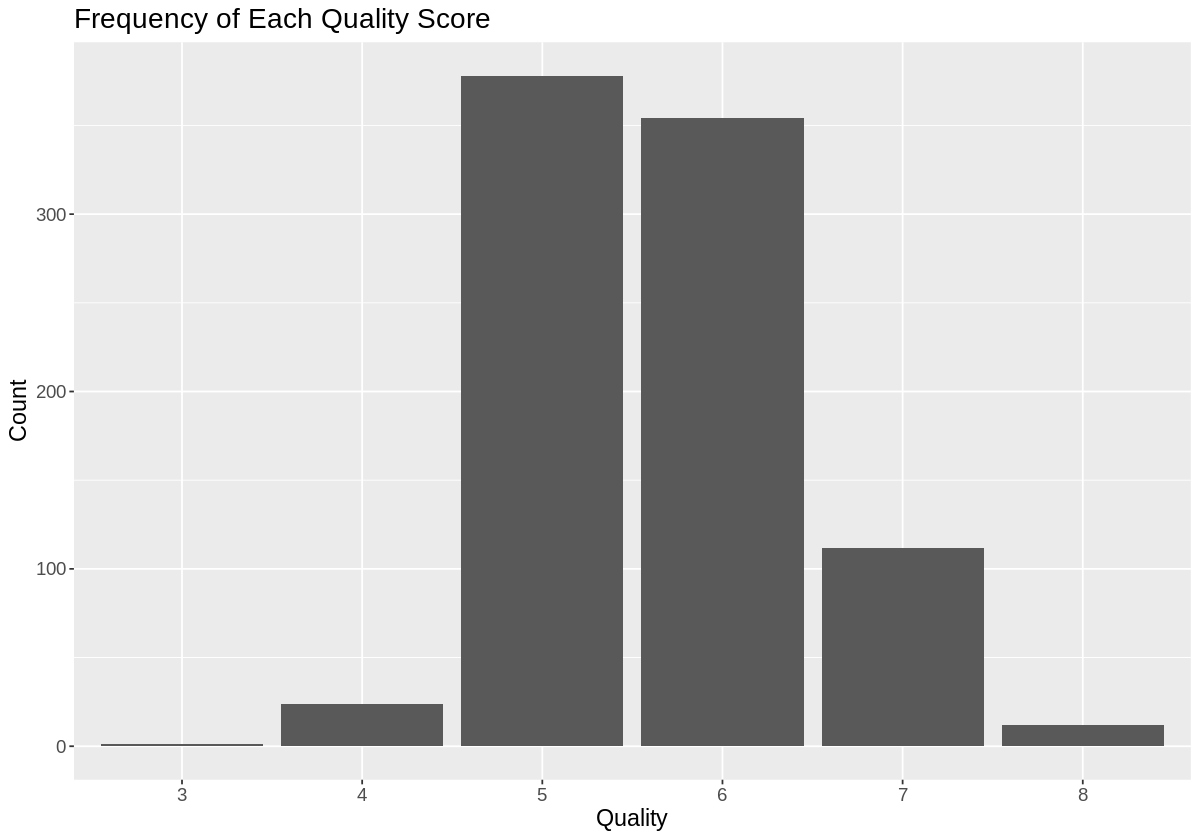

In [8]:
# count of observations per classifier plot
options(repr.plot.width = 10, options.repr.plot.height = 15)

train_data_quality_summary_plot <- train_data_quality_summary %>%
                                   ggplot(aes(x = quality, y = count)) +
                                   geom_bar(stat = "identity") +
                                   labs(x = "Quality", y = "Count", title = "Frequency of Each Quality Score") +
                                   theme(text = element_text(size = 14))
train_data_quality_summary_plot

*Figure 1: Counts for every observable quality class in the training dataset.*

From Table 2 and Figure 1, it is clear that there is a disproportiate number of wine quality classifications in our data set, with more classified in the average quality categories and less in the extreme categories.

#### Data Analysis

Our data analysis will be conducted using a classification model using the k-nearest-neighbours algorithm. This algorithm uses distances from data points in a data set where we know the category we are trying to predict. The distances are computed relative to a new observation in which we do not know the category for. The data points with the shortest distances away from the novel observation are used to predict the category of the new observation by a majority classifier. Meaning that the closest points vote on a class for the new observation. Depending on how many 'neighbours' we use, the accuracy may change. We must prevent overfitting the data to the noisy training data set and also underfitting our model which both reduce overall prediction accuracy. Thus, it is important we pick the appropriate k value in our model to create the best model for predicting subsequent novel observations accurately.

We begin with using predictor variable selection to find the best predictors in our model. We then tune the model with different values of k to determine the best number of neighbours for our classifier. After obtaining the best k value, we evaluate the accuracy of our model on a test set. We compare the accuracy of our model to another model containing predictor variables as suggested by the paper accompanying the data set. 

#### Predictor Selection of Our First Model

The wine dataset started with a fair amount of potential predictor variables. We must first select a subset of predictor variables from the training set to prevent irrelevant variables from negatively affecting our classifier model. The irrelevant predictors may add a random amount to the distances between observations. This would compromise the accuracy of our model. Selecting a subset of predictor variables would also help reduce computational time. 

We obtained the best predictor variables in R code using a forward selection method, as the best subset selection method would be too computationally expensive and inefficient on our large dataset. Although it is understood that the more variables used in K nearest neighbors classification, the worse it performs, we still decided to go ahead with using forward selection because it is a commonly used approach in variable selection (Radchenko & James, 2011). Moreover, as we do not have a large total number of predictor variables, this method would not pose as high of a risk on overestimating the accuracy of one of the training models.

To begin our analysis, we created an object dataframe that excluded the quality variable we are predicting. This was the only categorical variable in our dataset so no further alterations were required.

In [29]:
set.seed(7)

# determining predictors
data_subset <- train_data
names <- colnames(data_subset %>% select(-quality))

We then created an empty tibble to store our results of each model string's accuracy, a model specification for k-nn classification, and a 5-fold cross-validation object.

In [30]:
# empty tibble to store results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

The total number of predictors was stored as an object to be used in creating the model formula. 

Another object was created to store the selected predictors. 

In [31]:
# storing the total number of predictors
n_total <- length(names)

# storing selected predictors
selected <- c()

Next, we generated two for loops to generate our candidate models through iterative processes. One of which increases the predictor subset size by one and another that chose the best predictor to be added in the next model string. 

We created a model string using the paste and collapse function to make a model formula for all predictors.

For each set of possible predictor combinations, a recipe was created (and standardized to prevent disturbances in the distance calculations of the k-nearest neighbours) before being passed in a workflow that tuned the classifier using 5-fold cross-validation. The recipe used a model formula to test each set of predictors. We chose the best k value by collecting the metrics of the cross-validation accuracy and selecting the k with the highest obtained accuracy value.

The best k value was added into each set of predictors. The resulting accuracies were put into the empty dataframe to compare each model string.

In [55]:
set.seed(7)

# the first for loop - for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    
# for every predictor still not added yet
accs <- list()
models <- list()

# for the second for loop - adds best predictor in the next model string
for (j in 1:length(names)) {
        
# model string for the combination of predictors
preds_new <- c(selected, names[[j]])
model_string <- paste("quality", "~", paste(preds_new, collapse="+"))
        
# recipe created from the model string
data_recipe <- recipe(as.formula(model_string), 
                data = data_subset) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# tuning the KNN classifier with the recipe and model specification then collecting the accuracy for the best K.
acc <- workflow() %>%
        add_recipe(data_recipe) %>%
        add_model(spec) %>%
        tune_grid(resamples = data_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        summarize(mx = max(mean))

acc <- acc$mx %>% unlist()
    
# adding best k to the dataframe
accs[[j]] <- acc
models[[j]] <- model_string
}
    
jstar <- which.max(unlist(accs))
    
accuracies <- accuracies %>% 
              add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    
selected <- c(selected, names[[jstar]])
    
names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ alcohol,0.5197869
2,quality ~ alcohol+sulphates,0.5777369
3,quality ~ alcohol+sulphates+total_so2,0.6038676
4,quality ~ alcohol+sulphates+total_so2+residual_sugar,0.6174786
5,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides,0.6230250
6,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity,0.6356094
7,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2,0.6299080
8,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid,0.6220242
9,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid+fixed_acidity,0.6255432


*Table 3: Predictors model and accuracy results obtained from forward selection.*

Table 3 suggests that a classifier using six predictor variables (residual_sugar, alcohol, sulphates, total_so2, chlorides, and volatile_acidity) would provide the best accuracy (~64% accuracy). We used these variables in the remaining analysis accordingly.

#### Finding the Best K value in our classifier

Using our selected predictor variables, we begin tuning our classifier. 

We tuned our K-NN classifier with the selected variables and determined the best k using cross-validation. Using a workflow, we tuned the model to values of k ranging from 1-100 by 5. We collected the accuracies of the folds and plotted them over k-neighbours. 

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



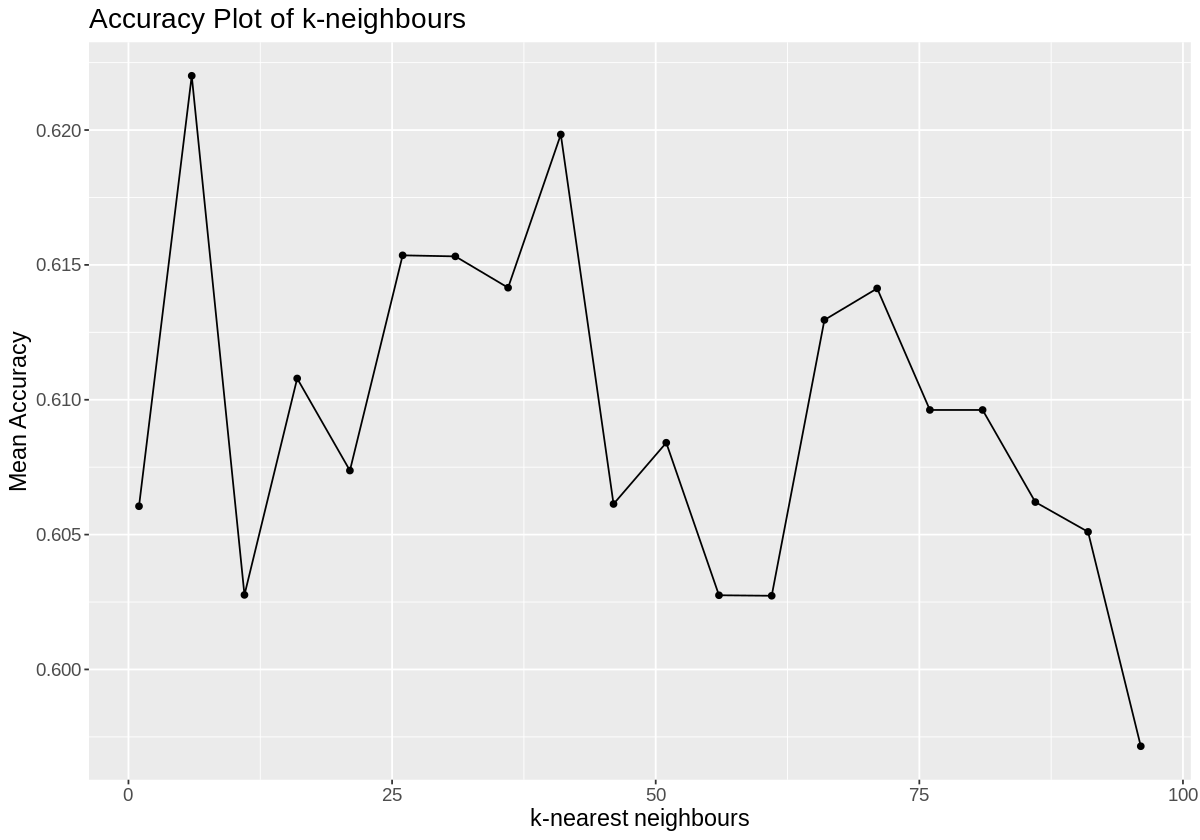

In [8]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, sulphates, total_so2, residual_sugar, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# tuning the model and specifying k-nn classification 
model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals <- tibble(neighbors = seq(1,100,5))

# tuning the model in a workflow
train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot <- ggplot(train_fit, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot

*Figure 2.1: Plot of k-neighbours (1-100 by 5) against accuracy in cross-validation.*

Looking at Figure 2.1, we see a variable plot of accuracy. We attribute this high varibility to the inherit properties of raw data. The best range of k values appears to be within k values of 25-60 with accuracies around 0.61. We decided to redo the model tuning procedure using k values within the specified range above to see if we get a more stable plot and to help identify the best k within this range.

We retried tuning the model for values of k ranging from 25-60 by 2. We plotted the accuracy against k values similar to what was done previously to get a sense of the accurracy variability. We also previewed the 6 highest accuracy k values using the tail function to identify the best k.

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



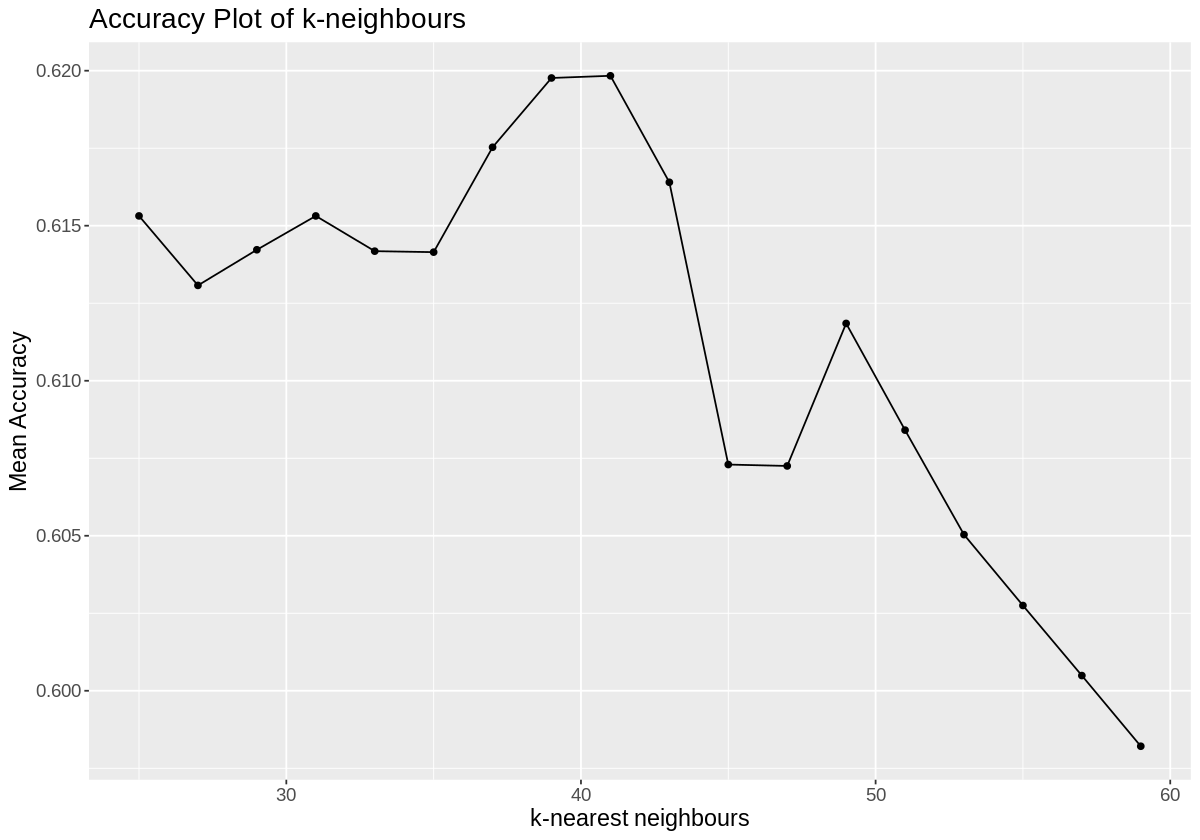

In [9]:
set.seed(7)

# new range of k values being tested
k_vals_2 <- tibble(neighbors = seq(25,60,2))

# tuning the model in a workflow
train_fit_2 <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals_2) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

k_plot_2 <- ggplot(train_fit_2, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_2

*Figure 2.2: Plot of k values (25-60 by 2) against accuracy in cross-validation.*

In [23]:
# seeing accuracies of our cross-validation 
tail(train_fit_2)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,multiclass,0.6153158,5,0.01664749,Model04
25,accuracy,multiclass,0.6153163,5,0.01139492,Model01
43,accuracy,multiclass,0.6164010,5,0.01265192,Model10
37,accuracy,multiclass,0.6175309,5,0.01377702,Model07
39,accuracy,multiclass,0.6197653,5,0.01130418,Model08
41,accuracy,multiclass,0.6198360,5,0.01405499,Model09


*Table 4: Estimation accuracies of k-neighbours in cross-validation.*

Looking at Figure 2.2, we found that a k value of 39 would be our best choice with an accuracy of ~0.62 (obtained in Table 4). The plot peaks around the late 30's and slowly declines just after 40. This decline in accuracy at the end suggests underfitting. Therefore, picking the highest accuracy at k = 41 (highest accuracy) might be a risky value to choose. Additionally, the standard error for a k values of 39 is lower than for 41. Consequently, we picked the second highest accuracy at a k value of 39, where surrounding values remain more stable in their accuracy.

We retrained our model to a k value of 39 and evaluated our accuracy on the test data set to see how generalizable the results are to furutre observations.

In [63]:
# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, sulphates, total_so2, residual_sugar, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# retraining the model with k = 39
best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
best_train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(best_model) %>%
                fit(predictor_train_data)

# creates a prediction on the test data
predicted <- predict(best_train_fit, test_data) %>%
             bind_cols(test_data)

In [64]:
# prediction accuracy of our model on the test data 
predict_accuracy <- predicted %>%
                    metrics(truth = quality, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")
predict_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.556314


*Table 5: Evaluation accuracy of the best model (k = 39) on test data.*

As determined by Table 5, we see that the accuracy of our model is estimated at ~0.56. This is slightly lower than our best k model (Table 4) in the tuning procedure. A lower accuracy is expected, since the training data used to create the model would have an influence on the model's accuracy in cross-validation. Since the accuracy is not that different than the accuracy obtained in Table 2, we may conclude that the model has moderate evaluation accuracy and may be sufficient at generalizing to future observations.

### Considering the Quality Class Imbalance on our Model

As seen in Figure 1, there is a disproportionately low amount of observations that fall under the low and high end of the quality score range. We consider them to be “rare classes”. Since the majority of observations has a score of 5 or 6, the model already has a good chance of being right if it predicts 5 or 6 each time. To avoid the bias from the dataset, we test our model on only the rare classes which will give insight to how well our model truly performs. 

In [66]:
test_data_rare <- test_data %>% filter(quality %in% c(3,4,8))

# prediction accuracy of our model on the rare quality observations of the test data 
predict_accuracy_rare <- predict(best_train_fit, test_data_rare) %>%
                            bind_cols(test_data_rare) %>%
                            metrics(truth = quality, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
predict_accuracy_rare

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0


*Table 6: Accuracy on rare-occurring quality classes (quality = 3, 4, or 8).*

The accuracy obtained in Table 6 reveals that the model performs very poorly on rare classes. This suggests that the rare classes may be affecting the accuracy of our model, perhaps to the imbalancing effect.

We wanted to see if the low accuracy in predicting rare classes is attributed to the quality class imbalance in our analysis or if it is related to how variable or unstable subjective classification of these extreme classes are.

To test this, we upsampled the lower count variables to match those with higher counts in our recipe and proceeded with the analysis as previously done to tune our KNN model. We want to see if our best model yields and evaluation accuracy differently if it includes upsampling or not.

The same steps were used, as previously done, to find the best predictor variables, the best k value in cross-validation and in evaluating the accuracy of our model on the test data.

In [45]:
set.seed(7)

# determining predictors
data_subset <- train_data
names_2 <- colnames(data_subset %>% select(-quality))

# empty tibble to store results
accuracies_2 <- tibble(size = integer(), 
                     model_string_2 = character(), 
                     accuracy = numeric())

# model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

# storing the total number of predictors
n_total_2 <- length(names_2)

# storing selected predictors
selected_2 <- c()

# the first for loop - for every size from 1 to the total number of predictors
for (i in 1:n_total_2) {
    
# for every predictor still not added yet
accs_2 <- list()
models_2 <- list()

# for the second for loop - adds best predictor in the next model string
for (j in 1:length(names_2)) {
        
# model string for the combination of predictors
preds_new_2 <- c(selected_2, names_2[[j]])
model_string_2 <- paste("quality", "~", paste(preds_new_2, collapse="+"))
        
# recipe created from the model string
data_recipe_2 <- recipe(as.formula(model_string_2), 
                data = data_subset) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors()) %>% 
                step_upsample(quality, over_ratio = 1)

# tuning the KNN classifier with the recipe and model specification then collecting the accuracy for the best K.
acc_2 <- workflow() %>%
        add_recipe(data_recipe_2) %>%
        add_model(spec) %>%
        tune_grid(resamples = data_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        summarize(mx = max(mean))

acc_2 <- acc_2$mx %>% unlist()
    
# adding best k to the dataframe
accs_2[[j]] <- acc_2
models_2[[j]] <- model_string_2
}
    
jstar_2 <- which.max(unlist(accs_2))
    
accuracies_2 <- accuracies_2 %>% 
              add_row(size = i, 
              model_string_2 = models_2[[jstar_2]], 
              accuracy = accs_2[[jstar_2]])
    
selected_2 <- c(selected_2, names_2[[jstar_2]])
    
names_2 <- names_2[-jstar_2]
}

accuracies_2

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string_2,accuracy
<int>,<chr>,<dbl>
1,quality ~ volatile_acidity,0.4108862
2,quality ~ volatile_acidity+density,0.5414108
3,quality ~ volatile_acidity+density+alcohol,0.5618789
4,quality ~ volatile_acidity+density+alcohol+chlorides,0.5732817
5,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2,0.5970492
6,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2,0.6028281
7,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates,0.5903341
8,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates+residual_sugar,0.5935690
9,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates+residual_sugar+pH,0.6094270


*Table 7: Forward selection on upsampled data.*

We decided on using the 6 predictor variable string. Although it doesn't have the highest accuracy, it is more practical than choosing the string with 10 or 11 variables.

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



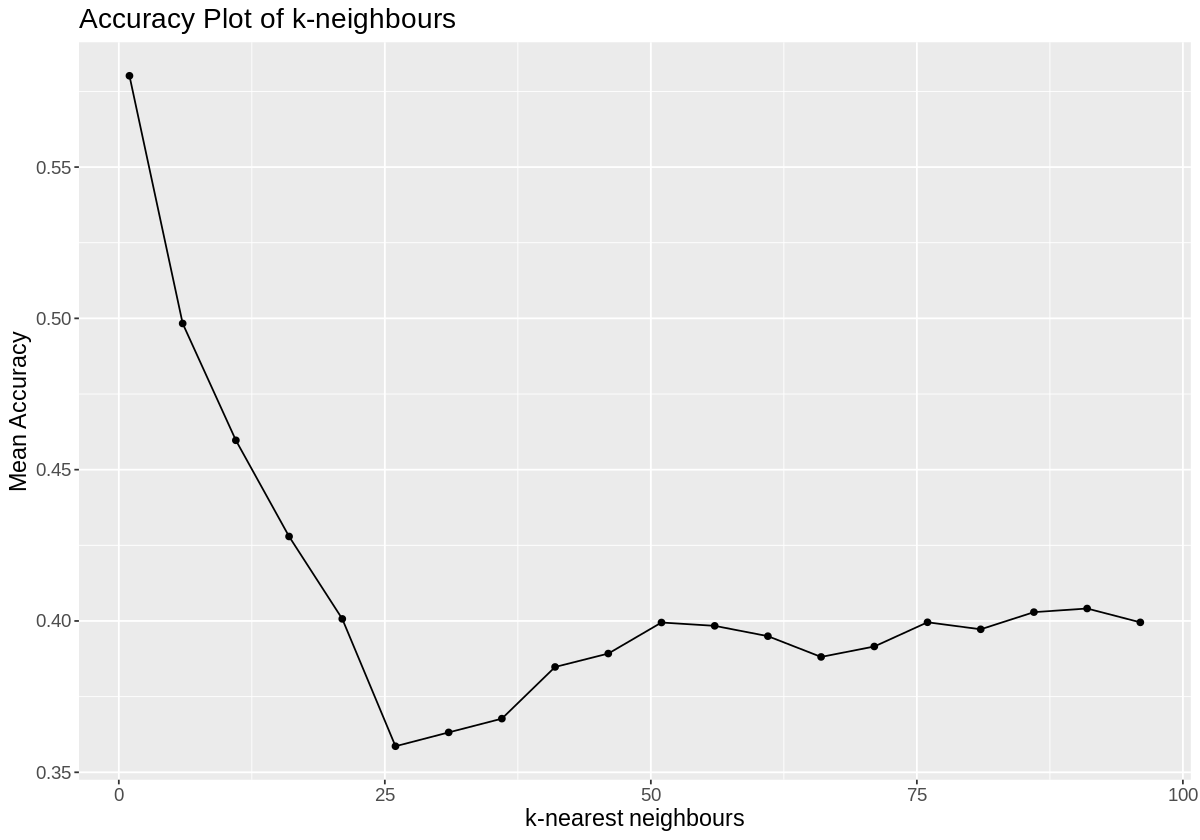

In [10]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals <- tibble(neighbors = seq(1,100,5))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_tune <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_model) %>%
                tune_grid(resamples = vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot_balance <- ggplot(balanced_tune, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_balance

*Figure 4: Accuracy plot of k-neighbours (1-100) in the upsampled cross-validation.*

This plot yields a poor plot of accuracy. To see if there is a stable high accuracy value, we limit the range to values 1-15.

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



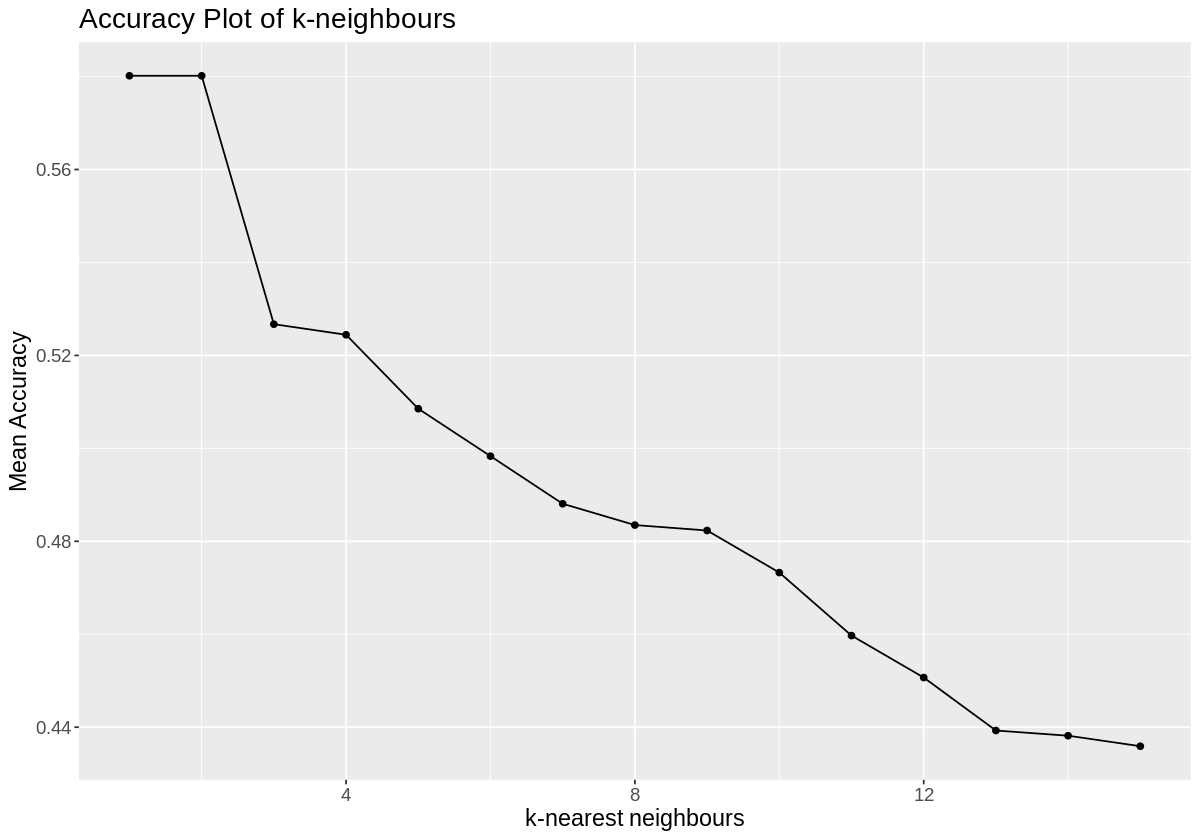

In [11]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals_balance <- tibble(neighbors = seq(1,15,1))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_tune2 <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_model) %>%
                tune_grid(resamples = vfold, grid = k_vals_balance) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot_balance2 <- ggplot(balanced_tune2, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_balance2

*Figure 5: Accuracy plot of k-neighbours (1-15) in the upsampled cross-validation.*

In [14]:
tail(balanced_tune2)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.4983180,5,0.01295943,Model06
5,accuracy,multiclass,0.5085262,5,0.01780376,Model05
4,accuracy,multiclass,0.5244358,5,0.01755747,Model04
3,accuracy,multiclass,0.5267086,5,0.01681556,Model03
1,accuracy,multiclass,0.5801646,5,0.01779827,Model01
2,accuracy,multiclass,0.5801646,5,0.01779827,Model02


*Table 8: Top accuracies of k-neighbours in upsampled cross-validation*

The highest accuracy (Table 8) k values seem to be at high risk of overfitting the data. Nevertheless, we chose a k value of 3 to test the evaluation accuracy on our test data. This was chosen based on its low standard error and high accuracy.

In [15]:
# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_upsample_best <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_best_model) %>%
                fit(predictor_train_data) 

# creates a prediction on the test data
predicted_upsample <- predict(balanced_upsample_best, test_data) %>%
             bind_cols(test_data)
                           
# prediction accuracy of our model on the test data 
balance_pred_acc <- predicted_upsample %>%
                    metrics(truth = quality, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")
balance_pred_acc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5238908


*Table 9: evaluation accuracy of our best upsampled model on the test data.*

The accuracy of our upsampled model on the test data is lower than the model we did before upsampling.

### Visualization

Observing in detail the results, we display the predictions made by our model on the test set via a confusion matrix. Reading from top-left then down along the diagonal denotes the count of quality predictions made by our model that match its true classification in the test set. All other positions in the matrix denote incorrect predictions.

In [37]:
# generates a confusion matrix
confusion <- predicted %>%
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   0   0   0   0   0
         5   5  15 166  77   5   0
         6   1   4  79 137  51   5
         7   0   0   1  16  23   1
         8   0   0   0   0   0   0

Helping to better visualize this confusion matrix, we plotted it on a heat map.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



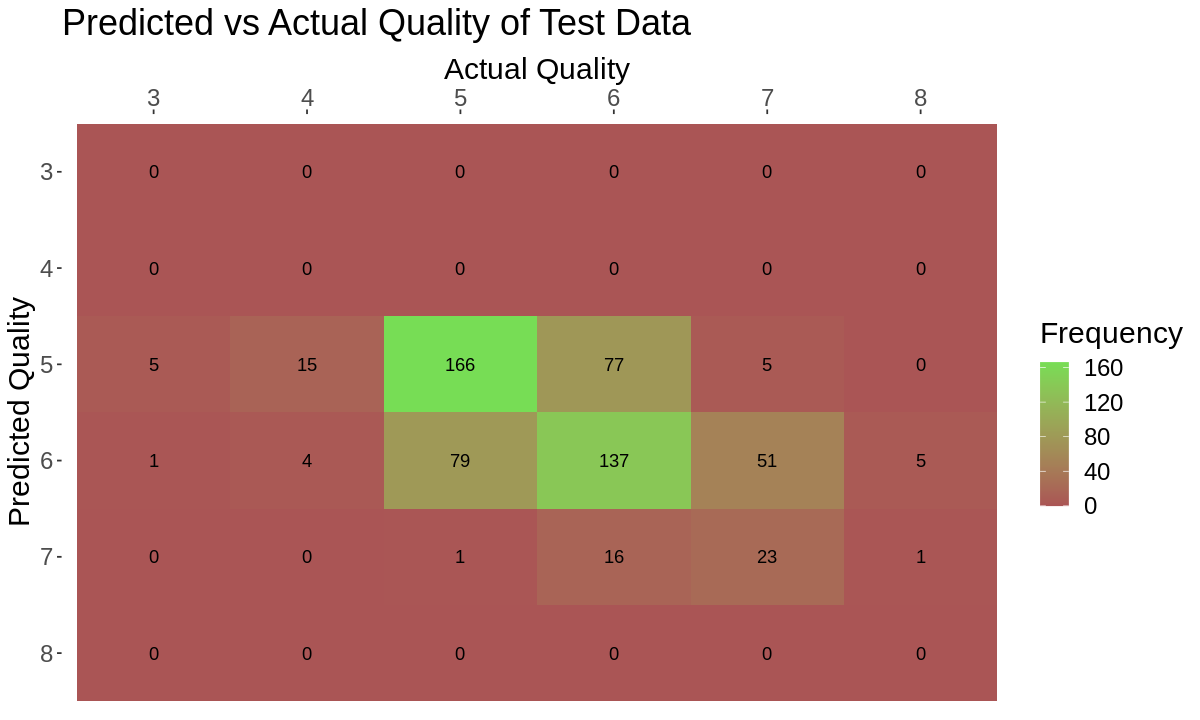

In [38]:
# creates a heatmap for the confusion matrix
confusion_plot <- confusion %>%
                  autoplot(type = "heatmap") +
                  scale_x_discrete(position = "top") +
                  scale_fill_gradient(low = "#aa5555", high = "#77dd55") +
                  labs(x = "Actual Quality", y = "Predicted Quality", fill = "Frequency") +
                  theme(legend.position = "right", text = element_text(size = 18)) +
                  ggtitle("Predicted vs Actual Quality of Test Data")
confusion_plot

*Figure 3.1: Heat map visualization of the classifier.*

Using a bar plot, we visualized the proportion of correct and incorrect predictions made by our model.

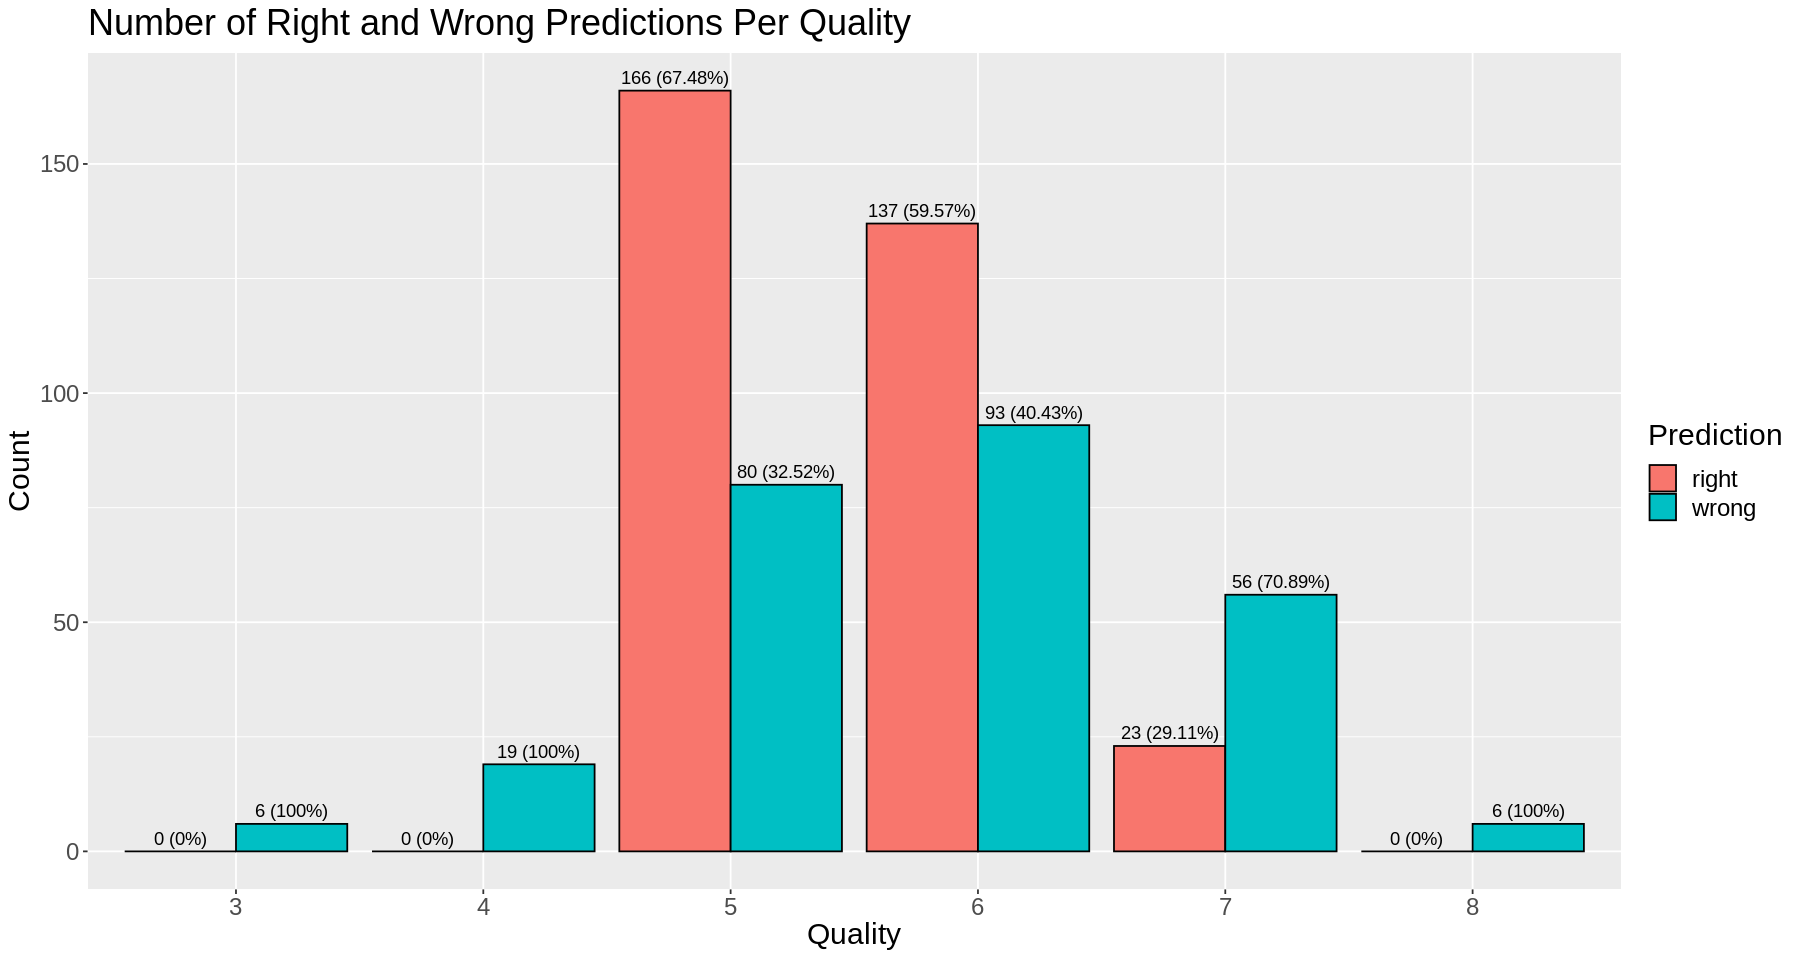

In [60]:
# converts the confusion matrix into a dataframe
confusion_df <- data.frame(confusion$table)
colnames(confusion_df)[which(names(confusion_df) == "Truth")] <- "quality"

# summarizes the number of right and wrong predictions
prediction_summary <- confusion_df %>%
                      group_by(quality) %>%
                      mutate(total_count = sum(Freq),
                             right = Freq,
                             wrong = total_count - Freq) %>%
                      filter(Prediction == quality) %>%
                      select(-Prediction, -Freq)

# produces the summarizing bar plot
options(repr.plot.width = 15, repr.plot.height = 8)
prediction_bar_plot <- prediction_summary %>%
                       pivot_longer(cols = c('right', 'wrong'),
                                    names_to = 'prediction',
                                    values_to = "count") %>%
                       ggplot(aes(x = quality, y = count, fill = prediction)) +
                       geom_col(colour = "black", position = "dodge") +
                       geom_text(aes(label = paste0(count, ' (', round(count * 100 / total_count, 2), '%)')),
                                 vjust = -0.5,
                                 position = position_dodge(width = .9)) +
                       theme(text = element_text(size = 18)) +
                       labs(title = "Number of Right and Wrong Predictions Per Quality", x = "Quality", y = "Count", fill = "Prediction")      
prediction_bar_plot

*Figure 3.2: Bar plot for the proportion of right and wrong predictions.*

In [63]:
# compares the ratio between right predictions and total observations
test_prediction_accuracy <- prediction_summary %>%
                            ungroup() %>%
                            select(total_count, right) %>%
                            summarize(accuracy = sum(right) / sum(total_count)) %>%
                            pull() %>%
                            round(3)
test_prediction_accuracy

[1] 0.556

The above number shows the accuracy of our current model at making predictions on our testing set.

## Discussion:

discussion here...

## References:

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J. (2009). Modeling wine 
	preferences by data mining from physicochemical properties. Decision 
	Support Systems. 47, 547-553. https://doi.org/10.1016/j.dss.2009.05.016.
 
Smith, D. V., & Margolskee, R. F. (2001). Making Sense of Taste. Scientific 
	American, 284, 32–39. http://www.jstor.org/stable/26059127
